In [1]:
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['axes.facecolor'] = '#fcfcfc'
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 400
plt.rcParams['mathtext.fontset'] = 'cm'

In [3]:
log_dir = Path("./leonardo_work/EUHPC_E03_068/jjitsev0/megatron_lm_reference/slurm_output")
assert log_dir.exists()
list(log_dir.iterdir())[:5]

[PosixPath('leonardo_work/EUHPC_E03_068/jjitsev0/megatron_lm_reference/slurm_output/open-sci-ref_model-0.1b_data-c4_tokenizer-GPT-NeoX-2_samples-30B_global_bs-144_context-4096_schedule-WSD_lr-6e-3_warmup-250_machine-LEONARDO-TEST_14297738.out'),
 PosixPath('leonardo_work/EUHPC_E03_068/jjitsev0/megatron_lm_reference/slurm_output/open-sci-ref_model-0.13b_data-c4_tokenizer-GPT-NeoX-2_samples-300B_global_bs-1008_context-4096_schedule-WSD_lr-6e-3_warmup-25000_machine-LEONARDO_14253258.out'),
 PosixPath('leonardo_work/EUHPC_E03_068/jjitsev0/megatron_lm_reference/slurm_output/open-sci-ref_model-1.7b_data-Nemotron-cc-2024-HQ-real-synth-mix_tokenizer-GPT-NeoX_samples-1000B_global_bs-1008_context-4096_schedule-WSD_lr-4e-3_warmup-25000_machine-LEONARDO_13977373.out'),
 PosixPath('leonardo_work/EUHPC_E03_068/jjitsev0/megatron_lm_reference/slurm_output/open-sci-ref_model-1.7b_data-SlimPajama_tokenizer-GPT-NeoX_samples-300B_global_bs-1008_context-4096_schedule-WSD_lr-4e-3_warmup-25000_machine-LEONAR

In [4]:
# Look for slurm output files that log a validation loss.
# Extract the latest lm-loss value for both validation and training.

val_pattern = re.compile(r"validation loss.*lm loss value:\s*([0-9.]+E[+-][0-9]+)")
lm_pattern  = re.compile(r"lm loss:\s*([0-9.]+E[+-][0-9]+)")

results = {}

for log_file in log_dir.glob("*.out"):
    latest_valid_loss = None
    latest_train_losses  = []

    # Read lines into memory
    with log_file.open(errors="ignore") as f:
        lines = f.readlines()
        
    # Check if file logs validation loss
    for line in lines:
        val_match = val_pattern.search(line)
        if val_match:
            latest_valid_loss = val_match.group(1)
    # Skip files without validation loss
    if not latest_valid_loss:
        continue

    # Extract latest training lm loss
    for line in lines:
        lm_match = lm_pattern.search(line)
        if lm_match:
            latest_train_losses.append(float(lm_match.group(1)))

    if not latest_train_losses:
        raise ValueError(f"No training lm loss found in {log_file.name}")

    mean_last_50 = sum(latest_train_losses[-50:]) / len(latest_train_losses[-50:])

    results[log_file.name] = {
        "latest_valid_loss": float(latest_valid_loss),
        "latest_train_loss": float(mean_last_50),
    }

print(results)

{'open-sci-ref_model-1.7b_data-Nemotron-cc-2024-HQ-real-synth-mix_tokenizer-GPT-NeoX_samples-1000B_global_bs-1008_context-4096_schedule-WSD_lr-4e-3_warmup-25000_machine-LEONARDO_13977373.out': {'latest_valid_loss': 1.864711, 'latest_train_loss': 1.1675899600000001}, 'open-sci-ref_model-0.13b_data-c4_tokenizer-GPT-NeoX_samples-300B_global_bs-1024_context-4096_schedule-WSD_lr-4e-3_warmup-25000_machine-LEONARDO_14253828.out': {'latest_valid_loss': 2.960102, 'latest_train_loss': 3.0314771600000006}, 'open-sci-ref_model-0.4b_data-DCLM_tokenizer-GPT-NeoX-2_samples-300B_global_bs-1000_context-4096_schedule-WSD_lr-4e-3_warmup-25000_machine-LEONARDO_14270775.out': {'latest_valid_loss': 2.74005, 'latest_train_loss': 1.23604444}, 'megatron_1B-C4_test_Leonardo_50B_bs-2M_const-lr_cooldown_resume_EXP_datasets.sbatch_10822301.out': {'latest_valid_loss': 2.606868, 'latest_train_loss': 2.6674977199999996}, 'megatron_1B-C4_test_Leonardo_50B_bs-4M_const-lr_cooldown_resume.sbatch_10860560.out': {'latest_v

In [5]:
float("1.906678E+00")
# float("1.17e-03")


1.906678

In [6]:
# Build a dataframe of results
df = pd.DataFrame.from_dict(results, orient="index").reset_index()
df = df.rename(columns={"index": "run"})

# Keep only OpenSci runs
df = df[df["run"].str.startswith("open-sci")]

# Add dataset column
df["dataset"] = df["run"].str.extract(r"data-([^_]+)")
print('Unique datasets: ', df["dataset"].unique())
print('Any unrecognized dataset?', df[df["dataset"].isna()])

df.reset_index(drop=True, inplace=True)
df

Unique datasets:  ['Nemotron-cc-2024-HQ-real-synth-mix' 'c4' 'DCLM' 'Pile' 'SlimPajama'
 'CommonCorpus' 'FineWeb-Edu-1.4T' 'C4' 'HPLT-2.0']
Any unrecognized dataset? Empty DataFrame
Columns: [run, latest_valid_loss, latest_train_loss, dataset]
Index: []


,run,latest_valid_loss,latest_train_loss,dataset
0,open-sci-ref_model-1.7b_data-Nemotron-cc-2024-...,1.864711,1.167590,Nemotron-cc-2024-HQ-real-synth-mix
1,open-sci-ref_model-0.13b_data-c4_tokenizer-GPT...,2.960102,3.031477,c4
2,open-sci-ref_model-0.4b_data-DCLM_tokenizer-GP...,2.740050,1.236044,DCLM
3,open-sci-ref_model-1.3b_data-Pile_tokenizer-GP...,1.925457,1.319041,Pile
4,open-sci-ref_model-1.7b_data-DCLM_tokenizer-GP...,2.503443,1.237598,DCLM
...,...,...,...,...
59,open-sci-ref_model-0.4b_data-HPLT-2.0_tokenize...,2.611701,1.492898,HPLT-2.0
60,open-sci-ref_model-1.7b_data-C4_tokenizer-GPT-...,2.597004,2.674872,C4
61,open-sci-ref_model-1.7b_data-C4_tokenizer-GPT-...,2.466978,2.514964,C4
62,open-sci-ref_model-1.3b_data-CommonCorpus_toke...,1.902509,0.708844,CommonCorpus


In [7]:
# Check for nan
df.isna().sum()

run                  0
latest_valid_loss    0
latest_train_loss    0
dataset              0
dtype: int64

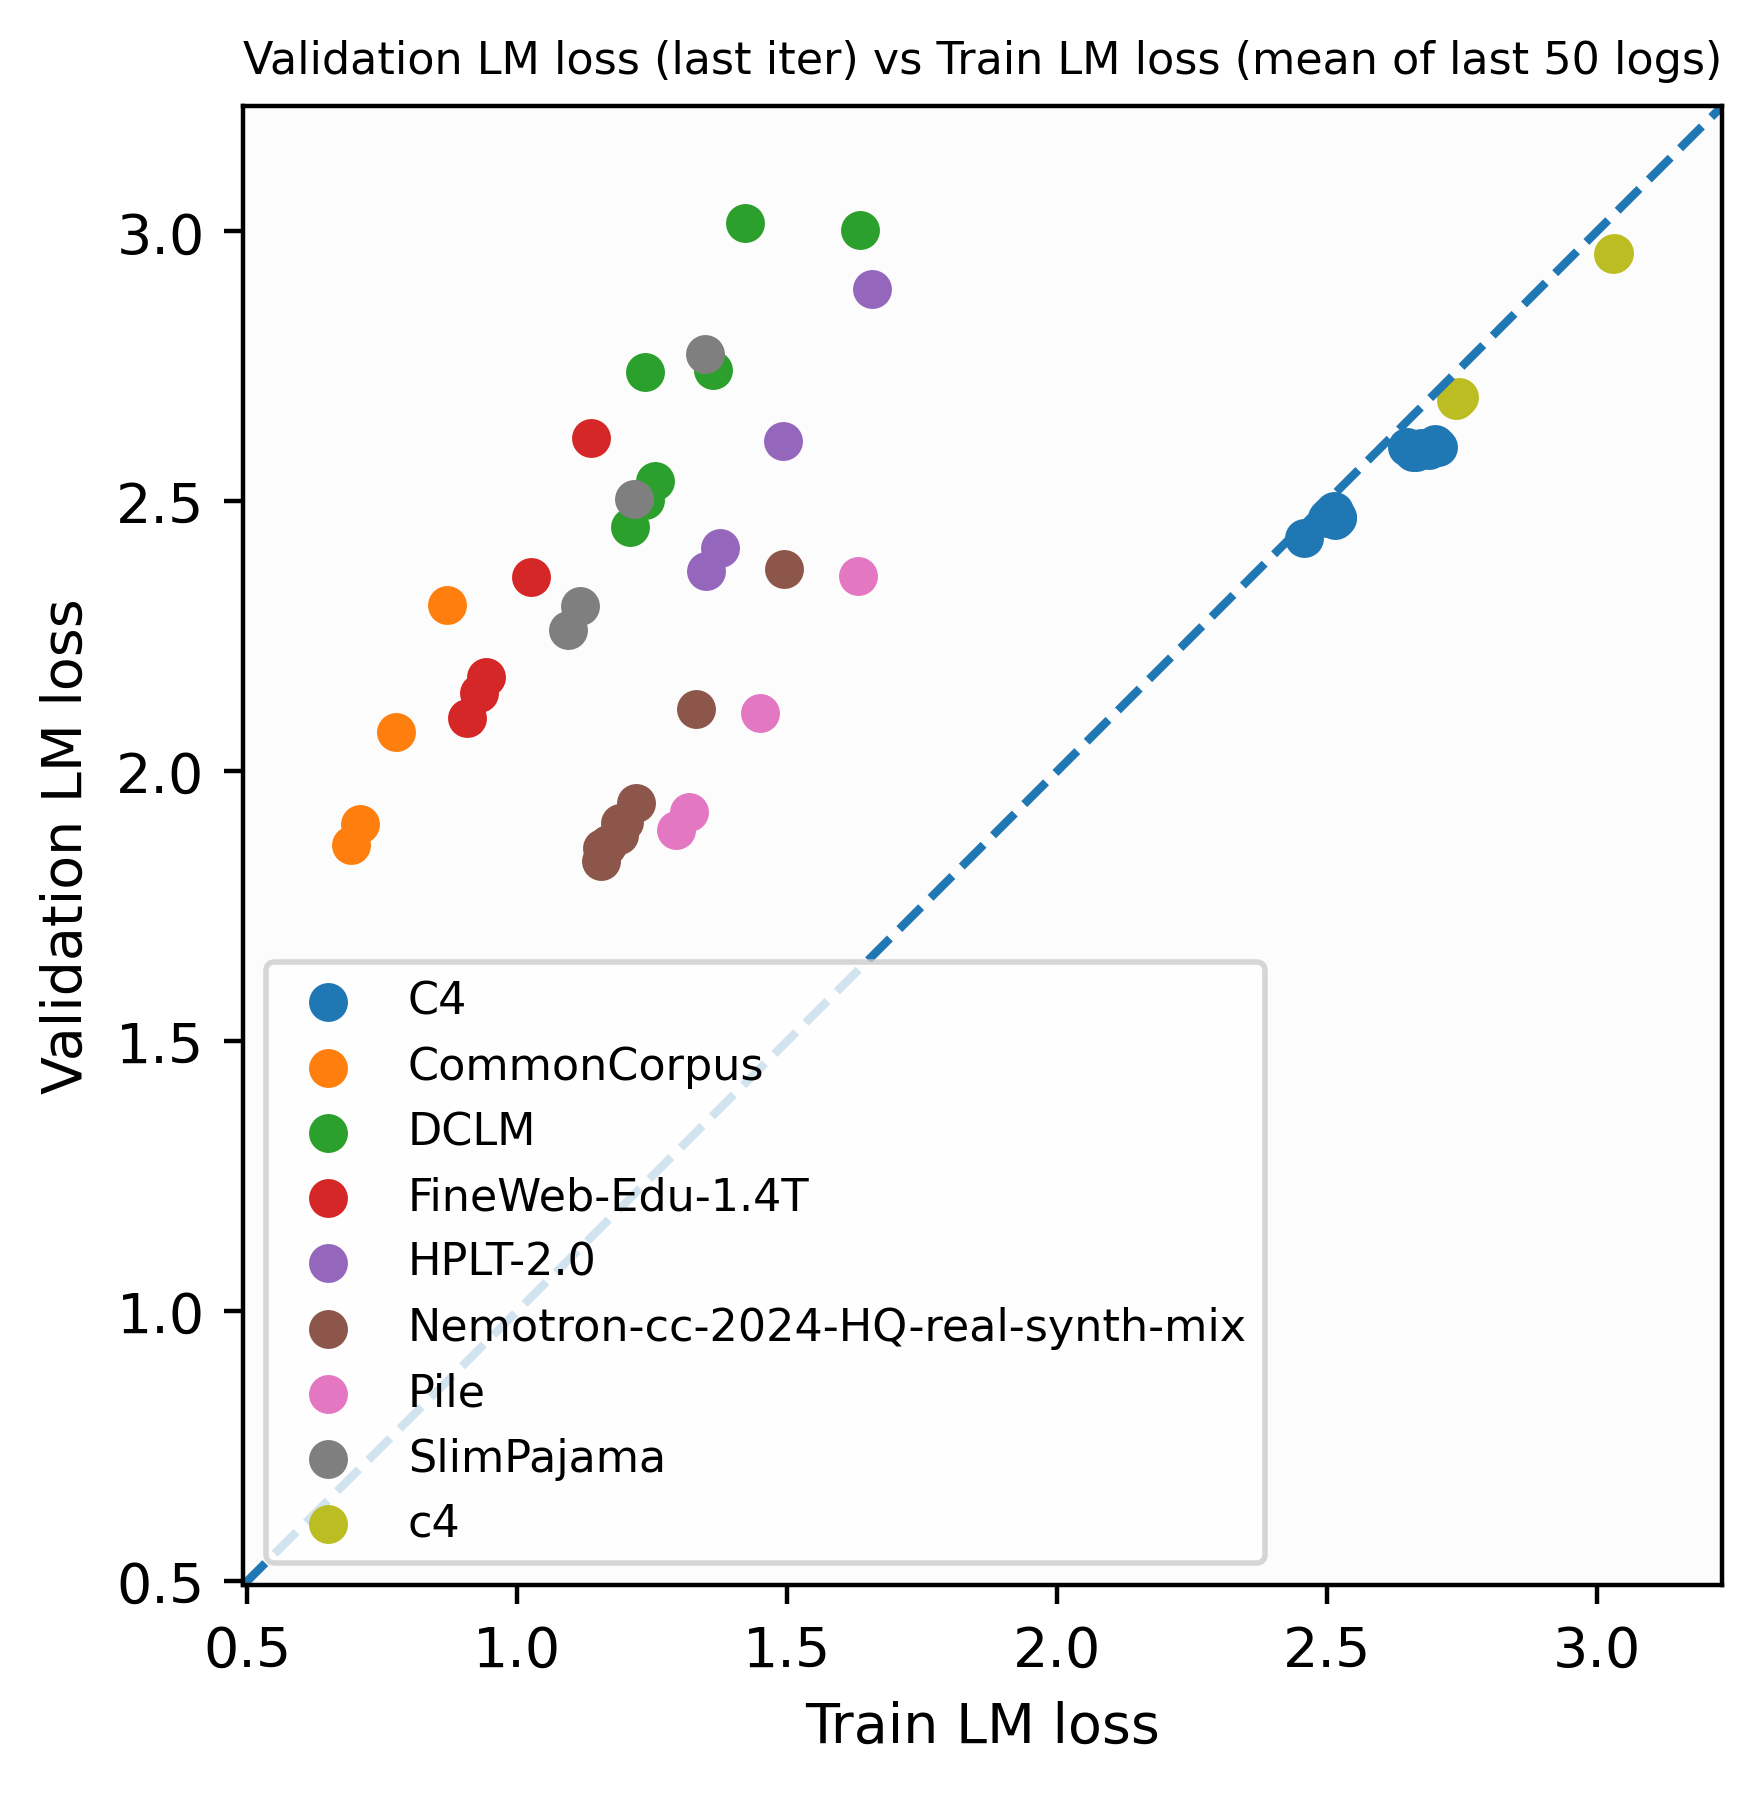

In [8]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure()

for dataset, g in df.groupby("dataset"):
    plt.scatter(g["latest_train_loss"], g["latest_valid_loss"], label=dataset)

# same scale on both axes
offset = 0.2
lims = [
    min(df["latest_train_loss"].min(), df["latest_valid_loss"].min()) - offset,
    max(df["latest_train_loss"].max(), df["latest_valid_loss"].max()) + offset,
]
plt.xlim(lims)
plt.ylim(lims)
plt.gca().set_aspect("equal", adjustable="box")

# bisector y = x
plt.plot(lims, lims, linestyle="--")

plt.xlabel("Train LM loss")
plt.ylabel("Validation LM loss")
plt.title("Validation LM loss (last iter) vs Train LM loss (mean of last 50 logs)", fontsize=8)
plt.legend(fontsize=8)
plt.show()


In [9]:
# Train loss is unrealistically small, let's check a CommonCorpus path
df[df['dataset'] == 'CommonCorpus']['run'].iloc[0]

'open-sci-ref_model-1.7b_data-CommonCorpus_tokenizer-GPT-NeoX_samples-300B_global_bs-1008_context-4096_schedule-WSD_lr-4e-3_warmup-25000_machine-LEONARDO_12766308.out'